In [2]:
import sys
sys.path.append("..")

from models.taylorf2 import taylorf2
import jax.numpy as jnp
from jax import grad, config
import jax
import matplotlib.pyplot as plt
import os 
import numpy as np
config.update("jax_enable_x64", True)
import corner

from src.samplers import samplers
from scripts.plot_helper_functions import collect_samples


In [5]:
# Define injection parameters

# Define prior ranges
priorDict = {}

# No birth-death seemingly needed
# injection = jnp.array([0, 0, 30.0, 0.24, 0.05]) 
# priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
# priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
# priorDict[2] = jnp.array([27.5, 32.5])
# priorDict[3] = jnp.array([0.2, 0.249])
# priorDict[4] = jnp.array([0.02, 0.07])

# More realistic
injection = jnp.array([0, 0, 30.0, 0.24, 0.5]) 
priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
priorDict[2] = jnp.array([27.5, 32.5])
priorDict[3] = jnp.array([0.1, 0.249])
priorDict[4] = jnp.array([0.2, 0.7])


model = taylorf2(injection, priorDict)


SNR is: 185.49376129849225


In [ ]:
# Confirm that analytical derivative agrees with JAX derivative

x = model.injection + np.random.uniform(low=0, high=0.0001, size=5)

test1 = jax.jacfwd(model.potential_single)(x)
test2 = model.gradient_potential_single(x)

# These disagree?
print(test1)
print(test2)

test3 = jax.jacfwd(model.strain)(x,10)
test4 = model.gradient_strain(x, 10)

# These agree
print(test3)
print(test4)

In [ ]:
# import numdifftools as nd 

# This yields overflow ever
# nd.Gradient(model.potential_single)(x)

# These yield different result............ WTF
print(jax.jacrev(model.potential_single)(x))
print(model.gradient_potential_single(x))
print(jax.jacfwd(model.potential_single)(x))

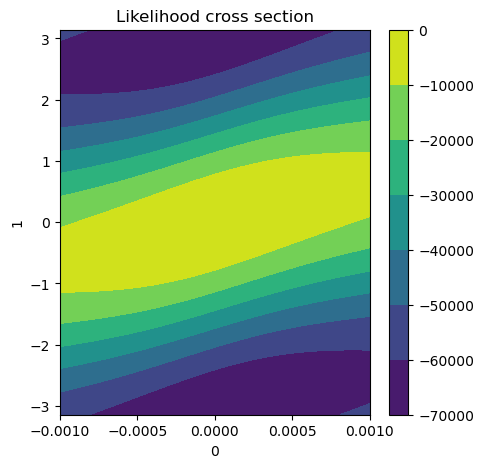

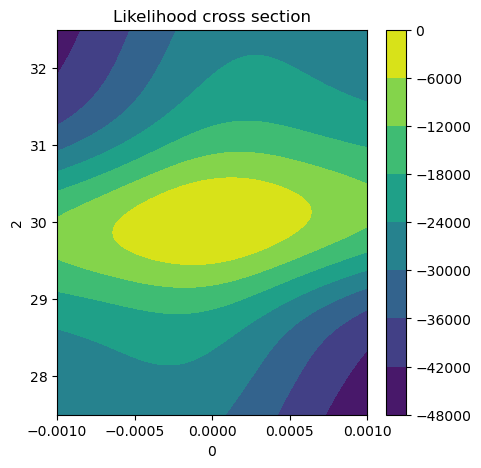

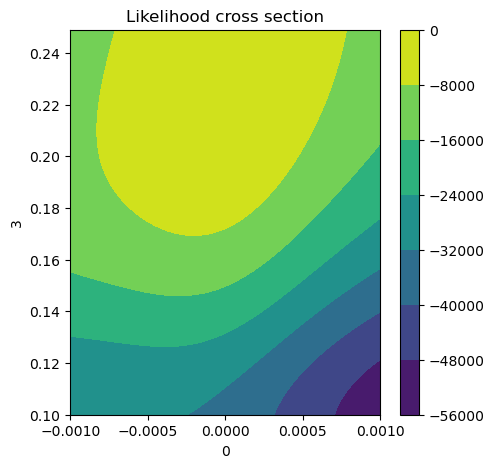

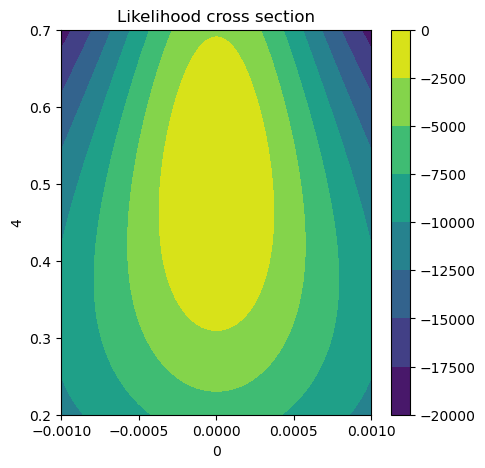

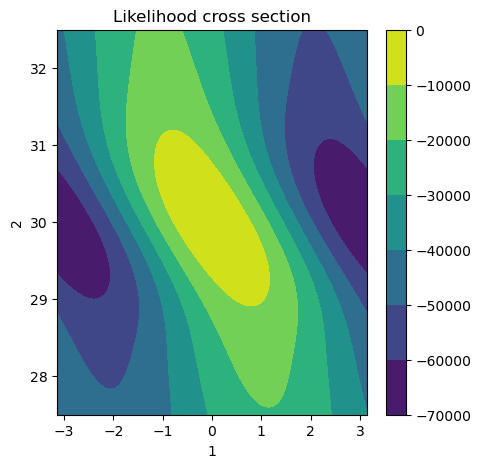

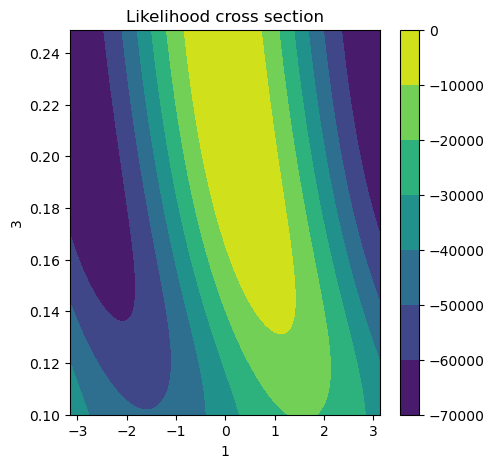

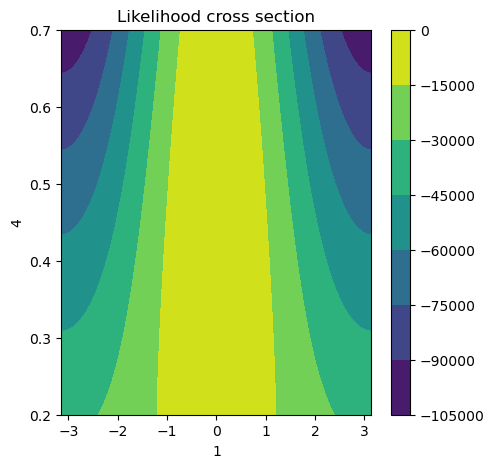

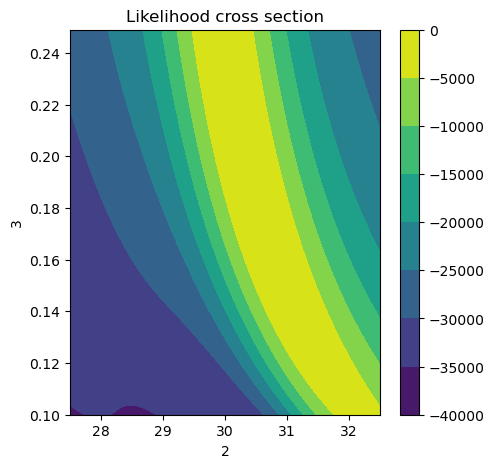

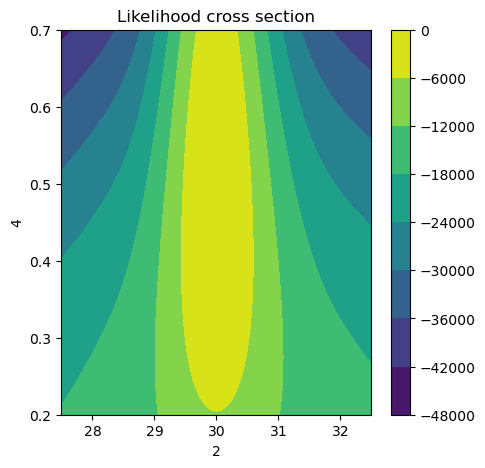

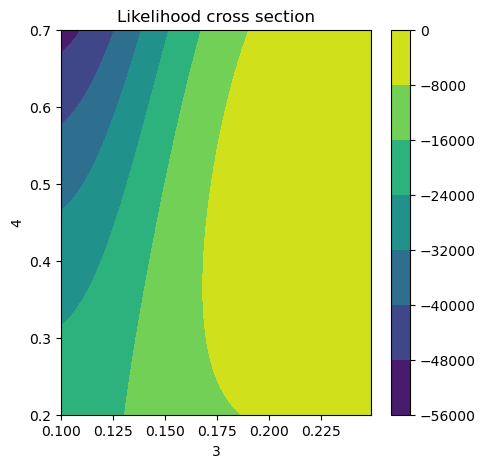

In [8]:
def getCrossSection(index1, index2, func, ngrid, DoF=5):
    # a, b are the parameters for which we want the marginals:
    x = np.linspace(priorDict[index1][0], priorDict[index1][1], ngrid)
    y = np.linspace(priorDict[index2][0], priorDict[index2][1], ngrid)
    X, Y = np.meshgrid(x, y)
    particle_grid = np.zeros((ngrid ** 2, DoF))
    parameter_mesh = np.vstack((np.ndarray.flatten(X), np.ndarray.flatten(Y))).T
    particle_grid[:, index1] = parameter_mesh[:, 0]
    particle_grid[:, index2] = parameter_mesh[:, 1]
    for i in range(DoF): # Fix all other parameters
        if i != index1 and i != index2:
            particle_grid[:, i] = np.ones(ngrid ** 2) * injection[i]
    Z = func(particle_grid).reshape(ngrid,ngrid)
    fig, ax = plt.subplots(figsize = (5, 5))
    cp = ax.contourf(X, Y, Z)
    plt.colorbar(cp)
    ax.set_xlabel(index1)
    ax.set_ylabel(index2)
    ax.set_title('Likelihood cross section')
    filename = str(index1) + str(index2) + '.png'
    path = os.path.join('marginals', filename)
    # fig.savefig(path)

posterior = lambda X: np.exp(-1 * model.getMinusLogPosterior_ensemble(X))

neg_potential = lambda X: -1 * model.getMinusLogPosterior_ensemble(X)

for i in range(5):
    for j in range(i+1, 5):
        # print('Getting cross section for %s' % pair)
        # getCrossSection(i, j, posterior, 200)
        getCrossSection(i, j, neg_potential, 200)

In [9]:
nParticles = 100
h = model.DoF / 10
nIterations = 10000
stride = 1

bd_kwargs = {'use': True, 
             'kernel_type': 'Lp',
             'p':2,
            #  'h': 0.01,
            #  'h': 1,
             'h': 1e-2,
            #  'h': 1,
             'start_iter': -1,
             'tau': 1e-4,
             'space': 'dual',
            #  'space': 'primal',
             'stride': stride}

sampler1 = samplers(model=model, nIterations=nIterations, nParticles=nParticles, profile=False, kernel_type='Lp', bd_kwargs=bd_kwargs)
kernelKwargs = {'h':h, 'p':1, 'M': jnp.eye(5)} 

# sampler1.apply(method='langevin', eps=0.0005, kernelKwargs=kernelKwargs)

# Parameter order 
# ---------------
# time_coalescence = x[0]
# phase_coalescence = x[1]
# chirp_mass = x[2]
# symmetric_mass_ratio = x[3]
# Amplitude = x[4]

# eps = np.array([0.005, 0.005, 0.0005, 0.5, 0.05])[np.newaxis, ...]
eps = np.array([0.001, 0.001, 0.001, 0.001, 0.001])[np.newaxis, ...] / 10
# eps = 0.01

# eps

sampler1.apply(method='langevin', eps=eps, kernelKwargs=kernelKwargs)
# sampler1.apply(method='langevin', eps=eps, kernelKwargs=kernelKwargs)

# %%

buffer in prior: 0.000500
buffer in prior: 1.570796
buffer in prior: 1.250000
buffer in prior: 0.037250
buffer in prior: 0.125000


Stepsize 0.000100 | Median bandwidth: 3.487531 | n_events: 0: 100%|██████████| 10000/10000 [06:40<00:00, 24.99it/s]


# Lets see what happens when I jax the outer loop!

In [ ]:
from src.reparameterization import reparameterization, sigma, logistic_CDF
V_X = self.model.getMinusLogPosterior_ensemble(X)
        
X = model._newDrawFromPrior(100)

samples = []

lax.scan(100):

    # Calculate gradient
    gmlpt_X, Hmlpt_X = model.getDerivativesMinusLogPosterior_ensemble(X)

    # Transform to unbounded domain
    eta, V_Y, gmlpt_Y, Hmlpt_Y = reparameterization(X, V_X, gmlpt_X, Hmlpt_X, model.lower_bound, model.upper_bound)

    # Perform update in unbounded domain
    eta += -gmlpt_Y * eps + np.sqrt(2 * eps) * np.random.normal(0, 1, size=(nParticles, model.DoF))

    # Convert samples back to bounded domain 
    X = sigma(logistic_CDF(eta), model.lower_bound, model.upper_bound)

    samples.append(X)

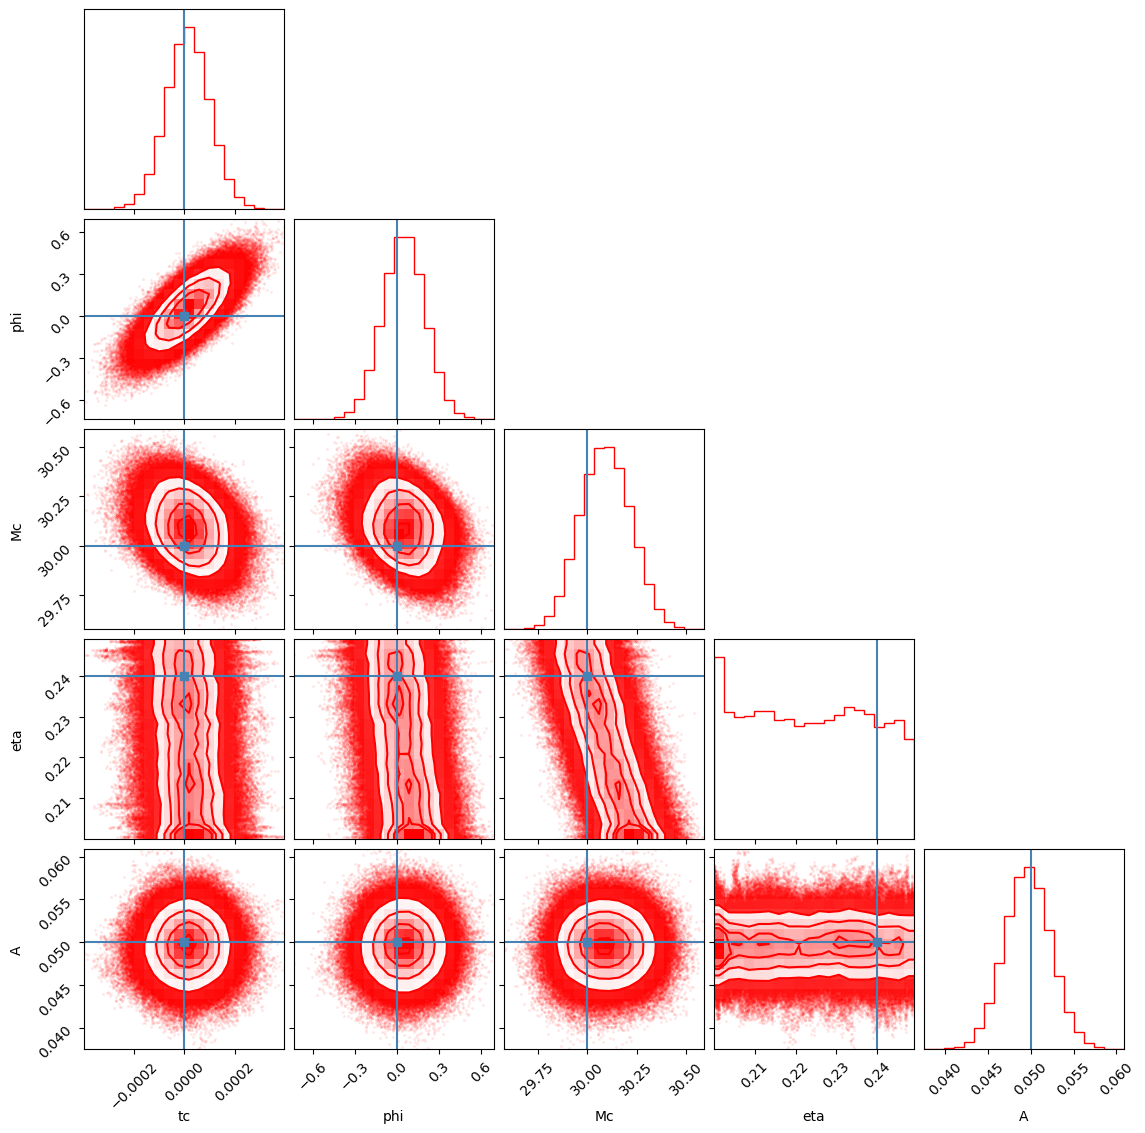

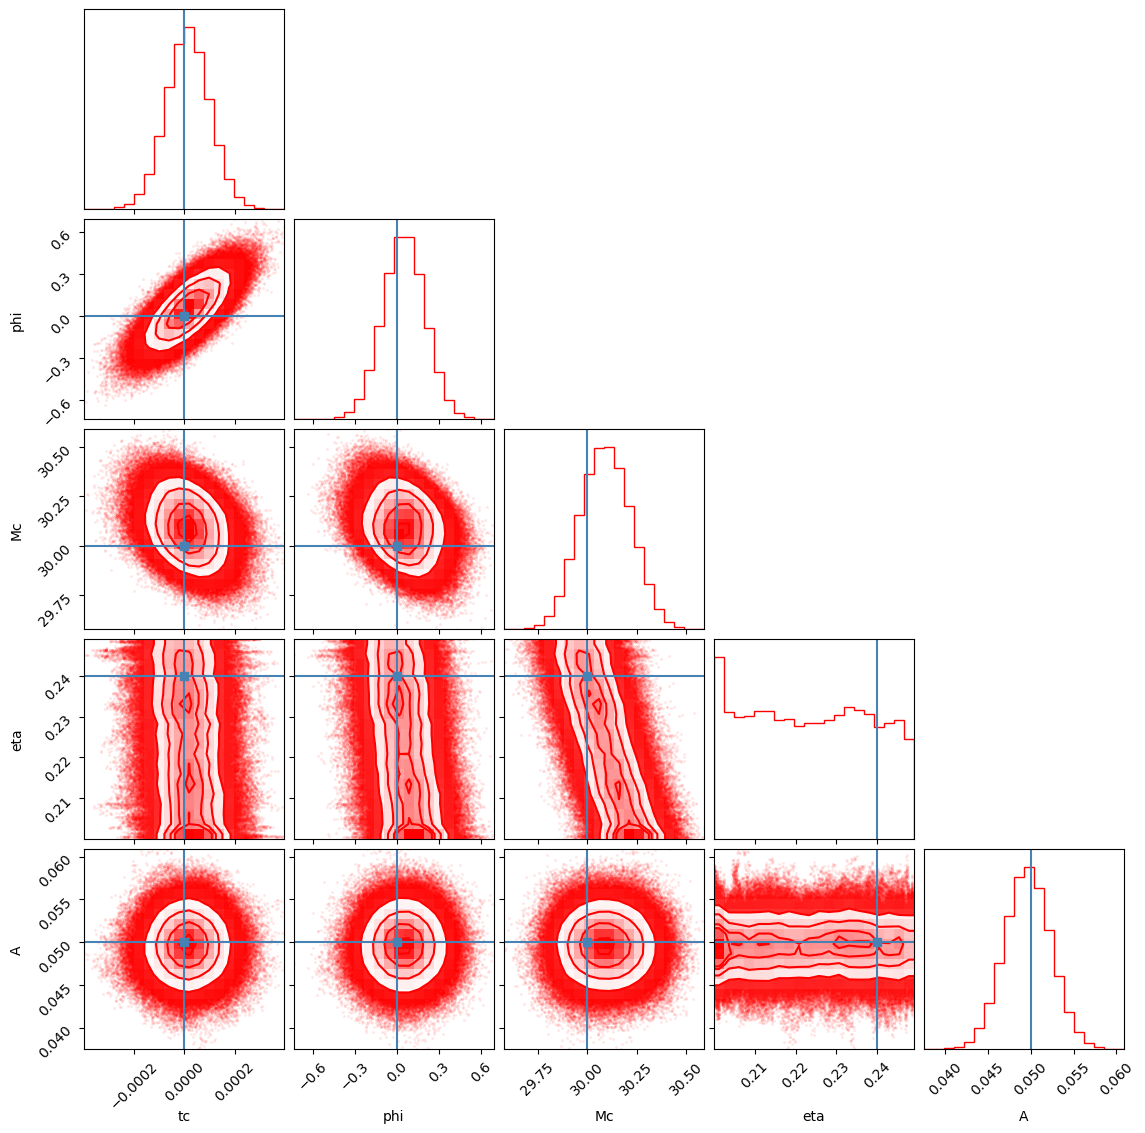

In [6]:
X1 = collect_samples(sampler1.history_path)
corner.corner(X1, color='r', labels=['tc', 'phi', 'Mc', 'eta', 'A'], truths=injection, hist_kwargs={'density':True})

In [ ]:
# %%capture
from scripts.create_contour import create_contour
from scripts.create_animation import animate_driver

posterior = lambda X: np.exp(-1 * model.getMinusLogPosterior_ensemble(X))

neg_potential = lambda X: -1 * model.getMinusLogPosterior_ensemble(X)

def xyz(index1, index2, func, ngrid, DoF=5):
    # a, b are the parameters for which we want the marginals:
    x = np.linspace(priorDict[index1][0], priorDict[index1][1], ngrid)
    y = np.linspace(priorDict[index2][0], priorDict[index2][1], ngrid)
    X, Y = np.meshgrid(x, y)
    particle_grid = np.zeros((ngrid ** 2, DoF))
    parameter_mesh = np.vstack((np.ndarray.flatten(X), np.ndarray.flatten(Y))).T
    particle_grid[:, index1] = parameter_mesh[:, 0]
    particle_grid[:, index2] = parameter_mesh[:, 1]
    for i in range(DoF): # Fix all other parameters
        if i != index1 and i != index2:
            particle_grid[:, i] = np.ones(ngrid ** 2) * injection[i]
    Z = func(particle_grid).reshape(ngrid,ngrid)

    return X, Y, Z 

ngrid = 200

# X, Y, Z = xyz(0, 1, posterior, ngrid)

# contour_file_path1 = create_contour(sampler1, model.lower_bound, model.upper_bound)

# dim1 = 3
# dim2 = 4
# for i in range(5):
#     X, Y, Z = xyz(3, i, neg_potential, ngrid)
#     animation_path1 = animate_driver('_', sampler1, 3, i, X, Y, Z)

for i in range(5):
    for j in range(i+1, 5):
        X, Y, Z = xyz(i, j, posterior, ngrid)
        animation_path1 = animate_driver('_', sampler1, i, j, X, Y, Z)

In [ ]:
a = np.array([])
a.type